Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data1.h5  gdrive  sample_data
(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)
Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 64)        18496     
________________________________________

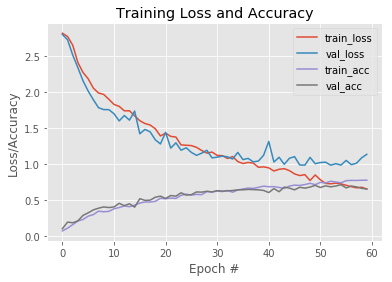

In [24]:

from google.colab import drive 
 
drive.mount('/content/gdrive')

#!unzip "/content/gdrive/My Drive/miscellaneous/data1-2.h5.zip"

!ls

import numpy as np 
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt


def build_baseline(width, height, depth, classes):

  # initialize the model along with the input shape to be
  # "channels last"
  model = tf.keras.Sequential()

  inputShape = (height, width, depth)
  
  # define the first CONV => => CONV => RELU layer
  model.add(tf.keras.layers.Conv2D (32, (3, 3), padding="same",input_shape=inputShape, activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  # softmax classifier
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(classes, activation='softmax'))

  return model

def build_arch_2(width, height, depth, classes):

  # initialize the model along with the input shape to be
  # "channels last"
  model = tf.keras.Sequential()

  inputShape = (height, width, depth)
  
  # define the first CONV => => CONV => RELU layer
  model.add(tf.keras.layers.Conv2D (32, (3, 3), padding="same",input_shape=inputShape, activation='relu'))  
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # second CONV => CONV => POOL layer set
  model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same",activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))  
  
  # second CONV => CONV => POOL layer set
  model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))  

  # first (and only) set of FC => RELU layers
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512,activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))    
  
  # softmax classifier
  model.add(tf.keras.layers.Dense(classes, activation='softmax'))

  return model

def build_arch_3(width, height, depth, classes):

  # initialize the model along with the input shape to be
  # "channels last"
  model = tf.keras.Sequential()

  inputShape = (height, width, depth)
  
  # first CONV => CONV => POOL layer set
  model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same",
  input_shape=inputShape, activation='relu'))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same",activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # second CONV => CONV => POOL layer set
  model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # first (and only) set of FC => RELU layers
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512,activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2)) 
  
  # softmax classifier
  model.add(tf.keras.layers.Dense(classes, activation='softmax'))
 

  return model


def loadDataH5():
  
  with h5py.File('data1.h5','r') as hf:
    trainX = np.array(hf.get('trainX')) 
    trainY = np.array(hf.get('trainY')) 
    valX = np.array(hf.get('valX')) 
    valY = np.array(hf.get('valY')) 
    print (trainX.shape,trainY.shape) 
    print (valX.shape,valY.shape)
    
    return trainX, trainY, valX, valY
  
def cnn_augmentation():
  
  NUM_EPOCHS = 100

  # load the training and testing data, then scale it into the
  trainX, trainY, testX, testY = loadDataH5()

  # initialize the optimizer and model
  print("Compiling model...")
  opt = tf.keras.optimizers.SGD(lr=0.01)

  model = build_arch_2(width=128, height=128, depth=3, classes=17)

  print (model.summary())

  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

  #data augmentation
  trainDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      )

  train_generator = trainDataGenerator.flow(
    trainX,
    trainY,
    batch_size=32)

  # The ImageDataSetGenerator for testing
  valDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator()

  validation_generator = valDataGenerator.flow(
    testX,
    testY,
    batch_size=32)

  H = model.fit_generator(train_generator,
         steps_per_epoch= 1020 // 32,
          epochs=NUM_EPOCHS,
          validation_data=validation_generator,
          validation_steps=340 // 32                       
         )

def cnn():
  
  NUM_EPOCHS = 60

  # load the training and testing data, then scale it into the
  trainX, trainY, testX, testY = loadDataH5()

  # initialize the optimizer and model
  print("Compiling model...")
  opt = tf.keras.optimizers.SGD(lr=0.01)

  #model = build_baseline(width=128, height=128, depth=3, classes=17)
  model = build_arch_2(width=128, height=128, depth=3, classes=17)
  #model = build_arch_3(width=128, height=128, depth=3, classes=17)

  print (model.summary())

  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
  

  # train the network
  print("Training network...")
  H = model.fit(trainX, trainY, validation_data=(testX, testY),batch_size=32, epochs=NUM_EPOCHS)


  
# executing CNN  
cnn_augmentation()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 60), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 60), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 60), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 60), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
